# Playground

This notebook contains notes and examples of some of the different machine learning concepts I encounter when learning. Essentially, this is a space for me to keep them for future use, as well as try them in practice. This kind of practice and note-taking also helps me remember the methods and understand them better. Hope you learn something from this as well!

Please note that this notebook **doesn't** reflect everything I know.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

# General helper functions:
def score_model(model, X_train, y_train, X_test, y_test, accuracy_call):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return accuracy_call(predictions, y_test)

## Feature Selection
This section contains some of the methods which help pick features and understand their importance in predicting the target variable.

### Mutual Information
Mutual information (MI) is a great general-purpose metric and is especially useful at the start when you might not know what model you would like to use. MI between two quantities measures the extent to which knowledge about one quantity reduces uncertainity about the other. Uncertainty is measured using a quantity from information theory known as 'entropy'. The entropy of a variable roughly means: "how many yes or no questions you would need to describe an occurrence of that variable, on average". The more questions you have to ask, the more uncertain you are about the variable. Mutual information is how many questions you expect the feature to answer about the target. Least possible score is 0.0. In theory, there is no limit; in practice, it is rare to get a value about 2.0. MI is logarithmic, so its rate of increase is slow. 

| Pros | Cons |
| ---- | ---- |
| Easy to use and interpret | Univariate (can't detect interactions between features) |
| Computationally efficient | Actual usefulnes still depends on the model. May need to transform a feature, as a result |
| Theoretically well-founded | |
| Resistant to overfitting | |
| Can detect any kind of relationship | |

Scikit-learn's implementation of MI treats discrete and continous variables differently. So, when using their implementation, make sure to specify which variables are discrete. This is done by passing a list argument in the `discrete` parameter of the function.

Source: [Kaggle](https://www.kaggle.com/ryanholbrook/mutual-information)

In [93]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [94]:
water_df = pd.read_csv("datasets/water_quality.csv")
water_df.head()

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.61,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1


In [95]:
X = water_df.copy()
y = X.pop("is_safe")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [96]:
score_model(XGBClassifier(), X_train, y_train, X_test, y_test, accuracy_score)

[11:27:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.97

In [13]:
mi_scores = mutual_info_classif(X, y, random_state=0)
mi_scores = pd.Series(mi_scores, name="MI Score", index=X.columns)
mi_scores.sort_values(ascending=True, inplace=True)

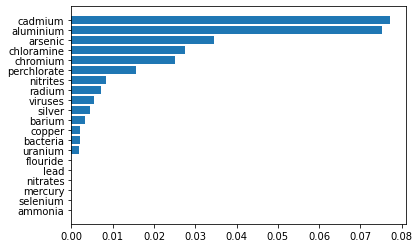

In [14]:
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.show()

<AxesSubplot:xlabel='is_safe', ylabel='cadmium'>

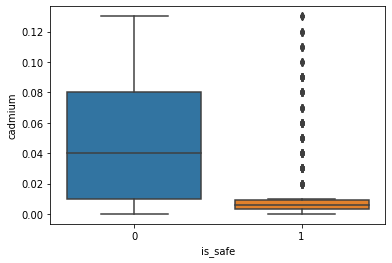

In [15]:
sns.boxplot(x="is_safe", y="cadmium", data=water_df)

<AxesSubplot:xlabel='is_safe', ylabel='ammonia'>

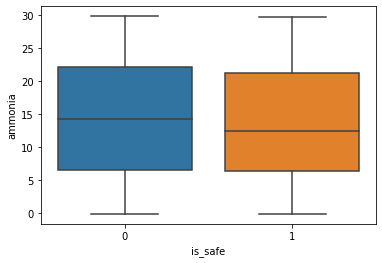

In [16]:
sns.boxplot(x="is_safe", y="ammonia", data=water_df)

Note that ammonia may still be an interaction variable (valuable in combination with another variable), so it is good to investigate this during actual analysis. This may also be the case for all of the other variables.

In [17]:
new_features = mi_scores[mi_scores > 0].index.values.tolist()
X_train_1 = X_train[new_features]
X_test_1 = X_test[new_features]

In [18]:
new_model = XGBClassifier()
score_model(new_model, X_train_1, y_train, X_test_1, y_test, accuracy_score)

[11:00:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.95375

The performance worsened, shows that there is interaction within the variables that we got rid of.

If the target variable is continious, use `mutual_info_regression`

### Chi-Square Test
The Chi-Square Test is a statistical test which is used to test the independence of two events/variables. In feature selection, the test is only used with categorical targets. Like other statistical tests, we establish a null hypothesis and an alternative hypothesis. The higher is the Chi-Square value, the higher is the dependence of a variable on another variable. Another important value we get with the test is the p-value. Similarly to other statistical tests, it suggests how statistically significant the results are. 

There are two ways of feature selection using this method. The first method is selecting the top n features with the highest Chi-Square value. This method works best if you know how many features you would like to have in your model. Another method is to use the resulting p-values in order to determine whether the column is statistically significant or not. As usual, pick an alpha value and compare it to the p-value.

| Pros | Cons |
| ---- | ---- |
| Relatively easy to use | Only works on categorical target variables|
| Two easy methods for feature selection | Gets complicated with highly cardinal categorical features | 
| Theoretically well-founded | In case of categorical features, need to make sure each category has more than 5 values |
| Makes no assumptions about the distribution of the data | | 


Sources: [Medium](https://towardsdatascience.com/categorical-feature-selection-via-chi-square-fc558b09de43)

In [19]:
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [20]:
loans = pd.read_csv("datasets/loan_data_set.csv", index_col=0)
loans.dropna(inplace=True)
loans.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


In [21]:
X = loans.copy()
y = X.pop("Loan_Status")
X["Gender"] = (X["Gender"] == "Male").astype(int)
X["Married"] = (X["Married"] == "Yes").astype(int)
y = (y == "Y").astype(int)
X.drop(["Education", "Self_Employed", "Property_Area", "Dependents"], axis=1, inplace=True)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
score_model(XGBClassifier(), X_train, y_train, X_test, y_test, accuracy_score)

[11:06:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7083333333333334

In [24]:
chi2_values, p_values = chi2(X_train, y_train)

In [25]:
chi2_series = pd.Series(chi2_values, index=X.columns)
chi2_series.sort_values(ascending=False)

CoapplicantIncome    11874.263112
ApplicantIncome        278.106943
LoanAmount              25.039383
Credit_History          16.256902
Loan_Amount_Term         4.663135
Married                  2.748794
Gender                   0.337003
dtype: float64

In [26]:
p_series = pd.Series(p_values, index=X.columns)
p_series

Gender               5.615645e-01
Married              9.732780e-02
ApplicantIncome      1.941471e-62
CoapplicantIncome    0.000000e+00
LoanAmount           5.617121e-07
Loan_Amount_Term     3.081688e-02
Credit_History       5.530775e-05
dtype: float64

Using p-values in order to determine which columns to use:

In [27]:
ALPHA = 0.05
new_features = p_series[p_series < ALPHA].index.values.tolist()
X_train_1 = X_train[new_features]
X_test_1 = X_test[new_features]

In [28]:
new_features

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [30]:
score_model(XGBClassifier(), X_train_1, y_train, X_test_1, y_test, accuracy_score)

[11:07:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.71875

Yay, an improvement!

In case you are using the first method for chi-square feature selection (top n features), it is more convinient to use sklearn's built in method `SelectKBest` in the `feature_selection` module.

In [31]:
from sklearn.feature_selection import SelectKBest

In [32]:
chi2_selector = SelectKBest(chi2, k=3)
X_2 = chi2_selector.fit_transform(X, y)

In [33]:
new_features = X.columns[chi2_selector.get_support()]  # chi2_selectkr.get_support() gets a mask for the columns/features used
X_train_2 = X_train[new_features]
X_test_2 = X_test[new_features]

In [44]:
score_model(XGBClassifier(), X_train_2, y_train, X_test_2, y_test, accuracy_score)

[11:08:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.5520833333333334

Despite using top 3 features, the accuracy greatly decreased. Perhaps it is worth increasing the amount of features.

In [45]:
chi2_selector = SelectKBest(chi2, k=4)
X_3 = chi2_selector.fit_transform(X, y)

In [46]:
new_features = X.columns[chi2_selector.get_support()]  # chi2_selectkr.get_support() gets a mask for the columns/features used
X_train_3 = X_train[new_features]
X_test_3 = X_test[new_features]

In [50]:
score_model(XGBClassifier(), X_train_3, y_train, X_test_3, y_test, accuracy_score)

[11:08:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6979166666666666

In [51]:
new_features

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Credit_History'], dtype='object')

The performance increased drastically, but we still obtained a better result when we used the p-value method. I think when the amount of features is small, it makes more sense to use the p-value method; however, if there are thousands of features, it is better to instead use the SelectKBest method, because that will narrow down the amount of features, which will save time when training and testing the model.

## Feature Creation

This section contains some techniques used in order to create new features based on old features.

### Principal Component Analysis

Principal Component Analysis (PCA) is an unsupervised learning technique used to surface the core patterns in the data. It creates new features by taking existing features and creating linear combinations of them. These new linear combinations are called principal components of the data. There will be as many principal components as there are features in the linear combinations. The weights used for the linear combinations are called loadings. They tell us what variation it expresses through its signs and magnitudes. PCA also tells us the amount of variation in each component. PCA makes this precise through each component's percent of explained variance. But there isn't necessarily a correlation between amount of variance explained and how useful of a feature it is. It is still good to use something like MI. 

The goal of Principal Component Analysis is to apply linear transformations to the data in order to minimize noise and redundancy. The result will reveal the most iportant characteristics about the data. After applying PCA, you'll have a set of principal components ranked according to how much variance they explain or how much they contribute to describing patterns in the data. PCA uses the covariance matrix to analyze the variance of each feature (relevant or pure noise), and the strength of linear relationships between pairs of features (helps to spot redundant features). 

There won't be a one-to-one relationship between features and principal components (most of the time). This is good, because it means that the principal component **encoded** the variation of only specific features and shows how those particular features interact with each other. That's the beauty of principal component analysis. Additionally, say we were able to encode the variation of 10 features in a single principal component analysis, that means that we were able to capture the information from 10 features into a single feature/component. This is a complex topic called [Factor Analysis](https://en.wikipedia.org/wiki/Factor_analysis). Need to look into it later. Although it's not always best to use only principal components, that's still really cool. Note that correlation and the loadings for each feature-pca pair will not necessarily be the same, will be different most-likely. 

There are two approaches to identify the principal components:
1. Calculate the eigenvectors of the covariance matrix.
2. Calculate the Singular Value Decomposition (SVD)

`scikit-learn` only has SVD in its implementation, while a library like `statsmodels` has both the eigenvectors approach and the SVD.

There are two ways to use PCA for feature engineering:

1. Use it as a descriptive techniques. Since the component tells you about variation, you could compute the MI scores for the components and see what kind of variation is most predictive of the target. That could give you ideas, which features to multiply, or divide, etc. Could even try clustering on one or more of the high-scoring components. 
2. Use components themselves as features. Can often be more informative than the original features. Especially useful when:
- The features are highly redundant (multicollinear), PCA will partition out the redundancy into one or more near-zero variance components. It does this by minimizing the covariance between pairs of features. 
- There's a lot of noise in the data. PCA will collect the signals and leave the noise, boosting the signal-to-noise ratio
- There're highly-correlated features, and your ML algorithm doesn't work well with them. PCA transforms correlated features into uncorrelated components, which could be easier for certain alogorithms to work with. 

Best practices:
- Only works with numeric features, like continious quantities or counts
- PCA is sensetive to scale, so it's good practice to standardize the data, unless there's a good reason not to. This will make principal components linearly independent, as well as orthogonal (principal components will make a 90 degree angle with each other). 
- Remove or constrain outliers, since they can have an undue influence on the results. 

The trade-off with using PCA and not the actual features is interpretability. When plotting features against each other, it's easier to interpret the patterns. Since principal components encode several features, it's not clear what features each principal component encodes, and what proportion of each feature has more impact on the patterns we are seeing. 

Methods to pick which PCA's should replace actual features:
1. Kaiser Criterion

    With this criterion, pick only the principal components that have eigenvalues greater than 1. Each eigenvalue is associated with a single eigenvector, which is a principal component. 
    
2. Explained variance
    
    With this method, you pick the total amount of variance in the dataset you want the components to encode. Usually, these cut-off values are 80% or 90%. So for instance, the cumilative explained variance will be 80% for the first 6 components, so you only use the first 6 components. Depends on the cut-off you establish, though. 
    
3. Scree plot
    
    With this method, we pick the components in a more visual way. We plot the eigenvalue for each component and use the elbow method to determine the cut-off point. The idea is to see where the "elbow" is for the plot and make that the cut-off point. It is a less precise method since it is much more visual and seems more subjective. 
    
Sources: [Kaggle](https://www.kaggle.com/ryanholbrook/principal-component-analysis), [Medium Article](https://towardsdatascience.com/principal-component-analysis-algorithm-in-real-life-discovering-patterns-in-a-real-estate-dataset-18134c57ffe7)

In [29]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from statsmodels.multivariate.pca import PCA as sm_pca

In [30]:
houses = pd.read_csv("datasets/houses_to_rent_v2.csv")
features = ["area", "rooms", "bathroom", "parking spaces"]
X = (houses[features] - houses[features].mean(axis=0)) / houses[features].std(axis=0) # z-score normalization
y = houses["total (R$)"]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [32]:
score_model(XGBRegressor(), X_train, y_train, X_test, y_test, mean_absolute_error)

2189.371605201211

In [33]:
pca = PCA()

In [45]:
X_pca = pca.fit_transform(X_train)
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names, index=X_train.index)
loadings = pd.DataFrame(pca.components_.T,  columns=component_names, index=X.columns)

In [46]:
mi_scores = mutual_info_regression(X_pca, y_train, random_state=0)
mi_scores = pd.Series(mi_scores, name="MI Score", index=X_pca.columns)
mi_scores.sort_values(ascending=True, inplace=True)

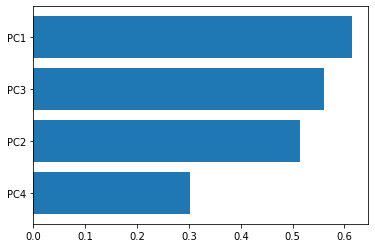

In [47]:
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.show()

In [48]:
X_train_1 = X_train.merge(X_pca, left_index=True, right_index=True)
X_test_1 = X_test.copy()
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_test_pca = pd.DataFrame(pca.transform(X_test_1), columns=component_names, index=X_test_1.index)
X_test_1 = X_test_1.merge(X_test_pca, left_index=True, right_index=True)

In [49]:
score_model(XGBRegressor(), X_train_1, y_train, X_test_1, y_test, mean_absolute_error)

2201.2308240607836

Performance has worsened! Let's try the second method.

In [50]:
loadings

,PC1,PC2,PC3,PC4
area,0.129898,-0.002398,0.028373,0.991118
rooms,0.572568,0.642498,-0.505847,-0.059006
bathroom,0.586195,0.096894,0.798184,-0.099443
parking spaces,0.558272,-0.760133,-0.325909,-0.065678


In [19]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()
X_train_2["rooms_parking_spaces_interaction"] = X_train_2["rooms"] / X_train_2["parking spaces"]
X_train_2["rooms_bathroom_interaction"] = X_train_2["rooms"] / X_train_2["bathroom"]
X_test_2["rooms_parking_spaces_interaction"] = X_test_2["rooms"] / X_test_2["parking spaces"]
X_test_2["rooms_bathroom_interaction"] = X_test_2["rooms"] / X_test_2["bathroom"]

In [20]:
score_model(XGBRegressor(), X_train_2, y_train, X_test_2, y_test, mean_absolute_error)

2210.1870969225724

Performance worsened by a decent amount. But this doesn't indicate that this isn't a good idea. Perhaps, this is the case for this specific dataset. Maybe we should also try using the `statsmodels` implementation, since the use of eigenvectors instead of SVD may help the performance of our model.

In [63]:
pca = sm_pca(X_train, standardize=True, method="eig")
X_pca_sm = pd.DataFrame(pca.transformed_data, columns=component_names, index=X_train.index)

In [85]:
X_train_2 = X_train.merge(X_pca_sm, left_index=True, right_index=True)
X_test_2 = X_test.copy()
loadings = pca.loadings.transpose().values.tolist()
for index, loadings in enumerate(loadings):
    X_test_2[f"PC{index+1}"] = X_test_2["area"] * loadings[0] + X_test_2["rooms"] * loadings[1] + \
                                X_test_2["bathroom"] * loadings[2] + X_test_2["parking spaces"] * loadings[3]

In [86]:
score_model(XGBRegressor(), X_train_2, y_train, X_test_2, y_test, mean_absolute_error)

2189.371605201211

Exact same result as with the default model. Perhaps, this suggests that the principal components perfectly captured the variance present in the default variables. It's still a bit weird that it's so perfect, so I'll need to double check later. Let's now try out the three methods of component selection.

Kaiser Criterion

In [88]:
pca.eigenvals

0    26354.375085
1     3301.911874
2     2505.344826
3     2050.368215
Name: eigenvals, dtype: float64

All components have an eigenvalue greater than 1, so they should all be used in the model.

Explained Variance:

In [89]:
pca.rsquare.values

array([0.        , 0.77032547, 0.86683874, 0.94006874, 1.        ])

If we set the threshold to 80%, it would be enough to just use the first two components. A lot of variance is explained in the first two components.

Scree plot

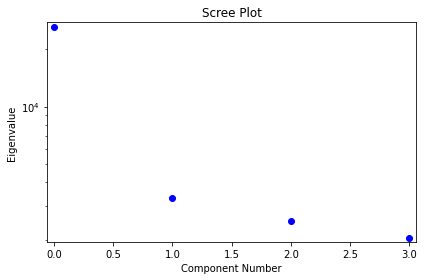

In [91]:
pca.plot_scree()
plt.show()

The elbow seems to be at the second component (1.0 mark), so it would make sense to only use the first two components using this method.

### Target Encoding

Targer encoding replaces a category from a categorical feature with some number derived from the target, an aggregate value. This, however, presents certain problems. Firstly, certain categories that can appear in production or testing data can be not present in the training dataset. Secondly, when a category appears a few times within the feature, any statistics calculated based on the category is unlikely to be accurate, making overfitting more likely. A solution to this is to add smoothing. The idea is to blend-in the category average with the overall average. Rare categories get less weight on their category average, while missing categories just get the overall average. 

In pseudocode:

`encoding = weight * in_category_average + (1 - weight) * overall_average`, where `weight` is a value between 0 and 1 calculated from category frequency. An easy way to calcualate the weight is by using an m-estimate:

`weight = n / (n+m)`, where `n` is the total number of times a category appears in the feature, and `m` is the "smoothing factor". 

Larger values of `m` put more weight on the overall estimate. When choosing a value for `m`, consider how noisy you expect the categories to be. Does the target value vary greatly within the category? Would you need a lot of data to get good estimates? If so, pick a high value for `m`. 

This is great for:
- High-cardinality features (a lot of categories)
- Domain-driven features. You might suspect that a categorical feature should be important even if it scored poorly with a feature metric. A target encoding can help reveal a feature's true informativeness.

In [70]:
from category_encoders import MEstimateEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder

In [71]:
df = pd.read_csv("datasets/houses_to_rent_v2.csv")
features = ["city", "area", "rooms", "bathroom", "parking spaces"]
X = df[features]
y = df["total (R$)"]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [73]:
old_X_train = X_train.copy()
old_y_train = y_train.copy()
old_X_test = X_test.copy()

In [74]:
X_encode = X_train.sample(frac=0.25, random_state=0)
y_encode = y_train[X_encode.index]

In [75]:
X_train.drop(X_encode.index, inplace=True)
y_train.drop(X_encode.index, inplace=True)

In [76]:
encoder = MEstimateEncoder(cols=["city"], m=1.0)
encoder.fit(X_encode, y_encode)
X_train = encoder.transform(X_train)

In [77]:
X_test = encoder.transform(X_test)

In [78]:
X_train

,city,area,rooms,bathroom,parking spaces
3083,3051.740514,70,1,1,2
508,6309.699087,40,1,1,1
3079,6309.699087,113,3,4,3
2036,2776.704732,40,2,1,1
49,3051.740514,48,1,1,1
...,...,...,...,...,...
7891,2776.704732,50,1,1,1
9225,5091.425623,90,3,2,1
4859,6309.699087,240,3,4,3
3264,5091.425623,106,2,2,1


In [79]:
mi_scores = mutual_info_regression(X_train, y_train, random_state=0)
mi_scores = pd.Series(mi_scores, name="MI Score", index=X.columns)
mi_scores.sort_values(ascending=True, inplace=True)

In [80]:
mi_scores

city              0.110187
rooms             0.301099
parking spaces    0.322353
bathroom          0.401508
area              0.527688
Name: MI Score, dtype: float64

Not the most useful feature, but still decent

In [82]:
old_features = ["rooms", "parking spaces", "bathroom", "area"]
score_model(XGBRegressor(), X_train[old_features], y_train, X_test[old_features], y_test, mean_absolute_error)

2213.5174530871063

In [83]:
X_train

,city,area,rooms,bathroom,parking spaces
3083,3051.740514,70,1,1,2
508,6309.699087,40,1,1,1
3079,6309.699087,113,3,4,3
2036,2776.704732,40,2,1,1
49,3051.740514,48,1,1,1
...,...,...,...,...,...
7891,2776.704732,50,1,1,1
9225,5091.425623,90,3,2,1
4859,6309.699087,240,3,4,3
3264,5091.425623,106,2,2,1


In [85]:
new_features = ["city", "rooms", "parking spaces", "bathroom", "area"]
score_model(XGBRegressor(), X_train[new_features], y_train, X_test[new_features], y_test, mean_absolute_error)

2062.925920669249

In [87]:
oh_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
oh_cols_train = pd.DataFrame(oh_encoder.fit_transform(old_X_train[["city"]]))
oh_cols_test = pd.DataFrame(oh_encoder.transform(old_X_test[["city"]]))
oh_cols_train.index = old_X_train.index
oh_cols_test.index = X_test.index

In [88]:
old_X_train.drop("city", axis=1, inplace=True)
old_X_test.drop("city", axis=1, inplace=True)

In [89]:
old_X_train = old_X_train.merge(oh_cols_train, left_index=True, right_index=True)
old_X_test = old_X_test.merge(oh_cols_test, left_index=True, right_index=True)

In [91]:
score_model(XGBRegressor(), old_X_train, old_y_train, old_X_test, y_test, mean_absolute_error)

2079.358791699082

Since our accuracy was higher using target encoding, we can say that the extra information gained using target encoding made up for the loss of data used for the encoding.

### Discretization

Discretization is the process through which we transform continious variables, models, or functions into a discrete form. We do this by creating a set of contiguous intervals (bins) that go across the range of our desire variable/model/function. Why use it?

1. **It fits the problem statement.** It is often easier to understand continious data (such as height) when divided and stored into meaningful groups or categories. We can divide height into the following groups: under 1.5m (short), 1.5-1.85 (medium height), 1.85+ (tall). We would consider the structure useful if we see no objective difference between variables falling under the same height class. 1.6m and 1.7m convey the same information (medium height). Discretization helps make our dataset easier to understand if it fits the problem statement.
2. **Interprets features.** Continious features have a smaller chance of correlating with the target variable due to infinite degrees of freedom and may have complex non-linear relationships. Thus, it may be harder to interpret such feature. After discretizing, groups corresponding to the target can be interpreted. 
3. **Incompatible with models/methods.** Certain models may not work well with continious features, such as a Random Forest Model, which works best with discrete features. Feature engineering methods, for example any entropy-based methods may not work with continious data, thus we would discretize variables to work with different models & methods. 
4. **Signal-to-noise ratio.** When we discretize a model, we are fitting it to bins and reducing the impact of small fluctuation in the data, which can be considered as noise. We can reduce this noise through discretization. Discretization smoothes the data, since each bin smoothes the fluctuations, reducing the noise in the data.

There are several different techniques of feature discretization:

- Supervised:
    1. Equal Width
    2. Equal Frequency
    3. K-Means
- Unsupervised:
    1. Decision Trees


Source: [Medium](https://towardsdatascience.com/an-introduction-to-discretization-in-data-science-55ef8c9775a2)

Equal Width:

Separates all possible values into `n` number of bins, each having the same width. To calculate interval width: `width = (max_value - min_value) / n`. 

- Can handle outliers

In [2]:
from sklearn.preprocessing import KBinsDiscretizer

In [4]:
walmart = pd.read_csv("datasets/walmart_sales_data.csv")
temperature = walmart[["Temperature"]]

In [5]:
equal_width_disc = KBinsDiscretizer(n_bins=3, encode="onehot", strategy="uniform")
equal_width_transformed = equal_width_disc.fit_transform(temperature).toarray()

In [6]:
columns = ["low_temp", "medium_temp", "high_temp"]

In [7]:
equal_width_dataframe = pd.DataFrame(equal_width_transformed, columns=columns, index=temperature.index)

In [8]:
equal_width_dataframe

,low_temp,medium_temp,high_temp
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
6430,0.0,1.0,0.0
6431,0.0,1.0,0.0
6432,0.0,1.0,0.0
6433,0.0,1.0,0.0


In [9]:
equal_width_disc.n_bins_

array([3])

In [10]:
equal_width_disc.bin_edges_

array([array([ -2.06      ,  32.00666667,  66.07333333, 100.14      ])],
      dtype=object)

Equal Frequency:

Separates all values into `n` number of bins, each with the same amount of observations. May correspond to quantile values as well.

- Improves value spread
- Can handle outliers

In [11]:
equal_freq_disc = KBinsDiscretizer(n_bins=3, encode="onehot", strategy="quantile")
equal_freq_transformed = equal_freq_disc.fit_transform(temperature).toarray()

In [12]:
equal_freq_dataframe = pd.DataFrame(equal_freq_transformed, columns=columns, index=temperature.index)

In [13]:
equal_freq_dataframe

,low_temp,medium_temp,high_temp
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
6430,0.0,1.0,0.0
6431,0.0,1.0,0.0
6432,0.0,1.0,0.0
6433,0.0,1.0,0.0


In [14]:
equal_freq_disc.bin_edges_

array([array([ -2.06,  52.54,  70.71, 100.14])], dtype=object)

Quiet different values and bin edges. 

K-Means Clustering:
Separates observations using the K-Means clustering algorithm. 

- Can handle outliers, but a centroid bias may exist

In [15]:
k_means_disc = KBinsDiscretizer(n_bins=3, encode="onehot", strategy="kmeans")
k_means_transformed = k_means_disc.fit_transform(temperature).toarray()

In [16]:
k_means_dataframe = pd.DataFrame(k_means_transformed, columns=columns, index=temperature.index)

In [17]:
k_means_dataframe

,low_temp,medium_temp,high_temp
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
6430,0.0,1.0,0.0
6431,0.0,1.0,0.0
6432,0.0,1.0,0.0
6433,0.0,1.0,0.0


In [18]:
k_means_disc.bin_edges_

array([array([ -2.06      ,  44.86965209,  67.15690969, 100.14      ])],
      dtype=object)

Different bin edges again, showing how distinct the three methods are. I think to pick the 'best' method for a particular situation/varible, it is best to check bin edges and see if they suit your criteria.

Decision Trees:
We use this method if we want the algorithm to identify the optimal number of bins. 

In [22]:
from feature_engine.discretisation import DecisionTreeDiscretiser

In [33]:
temperature_X = temperature.copy()
temperature_y = pd.DataFrame()
temperature_y["target"] = walmart["Weekly_Sales"]

In [40]:
disc = DecisionTreeDiscretiser(cv=3,
                               scoring='neg_mean_squared_error',
                               variables=['Temperature'],
                               regression=True, random_state=0)
decision_tree_dataframe = disc.fit_transform(temperature_X, temperature_y)

In [41]:
decision_tree_dataframe

,Temperature,target
0,1.068871e+06,1643690.90
1,1.068871e+06,1641957.44
2,1.068871e+06,1611968.17
3,1.068871e+06,1409727.59
4,1.068871e+06,1554806.68
...,...,...
6430,1.068871e+06,713173.95
6431,1.068871e+06,733455.07
6432,1.068871e+06,734464.36
6433,1.068871e+06,718125.53


In [42]:
decision_tree_dataframe["Temperature"].unique()

array([1068871.05802707,  938067.62011457,  650155.25988506,
        865423.98123967])

In [32]:
disc.binner_dict_

{'Temperature': GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
              param_grid={'max_depth': [1, 2, 3, 4]},
              scoring='neg_mean_squared_error')}

It is unclear how the values were obtained, need to look more into this. Why does the temperature column have such high values now?

Also need to implement evaluation later on.

## Models and Other

### Stochastic Gradient Descent

Stochastic Gradient Descent is a stochastic/probabilitic variation of gradient descent. So, what is gradient descent? Gradient descent is one of the most popular methods of model optimization. This method minimizes the loss/cost function. The idea behind this is to find an efficient way of reaching the minimum of a function. The assumption is that the cost function needs to be a differentiable convex function. 

The algorithm starts off by picking a value at random as a starting point. While the gradient hasn't converged / isn't 0, the algorithm will compute the slope at the random value and then go in the opposite of the direction of the gradient (down). It will update the point and repeat the steps. The way this works in machine learning is that the algorithm picks the parameters for the model at random and then modifies them in order to achieve the minimum of the given cost function. 

There are two parameters you can use with Gradient Descent. First one is the learning rate. This determines how far the algorithm steps when modifying the parameters for the model. The second one is convergence threshold; if the new gradient point hasn't changed more than the convergence threshold, the algorithm considers the minimum to be found and stops iterating. 

Sometimes, the learning rate might be too high or too small. A good indicator of a high learning rate is if the gradient is not decreasing at every step. A good indicator of a low learning rate is if the algorithm takes a long time to run. 

There are two issues with gradient descent:

1. Calculating derivatives for the entire dataset is time consuming. 
2. Memory required is proportional to the size of the dataset.

In order to avoid these issues, we use Stochastic Gradient Descent (SGD). SGD is a probabilistic approximation of gradient descent. It is an approximation because at each iteration, the algorithm calculates the gradient for one observation picked at random, instead of calculating the gradient for the entire dataset. This provides us with significant improvement, especially when the dataset contains a lot of observations. The only condition in SGD is that the expected value of the observation picked at random is a subgradient of the function. 

The trade-off is that the updates have a higher variance, making the convergence much harder. New variations of SGD have developed to tackle these issues, like mini-batch SGD. Instead of only taking one point, the algorithm calculates the derivative for a batch of data. Additionally, SGD is sensetive to feature scaling.

With sklearn's implementation, you have to import a `SGDClassifier` or `SGDRegressor` and then set the parameters correctly in order to get the model you want. Here's the list below:

For `SGDRegressor`:
- loss="squared_loss" - ordinary least squares linear regression
- loss="huber" - huber loss for robust regression
- loss="epsilon_insensitive" - linear Support Vector Regression

For `SGDClassifier`:
- loss="hinge" - gives a soft-margin linear Support Vector Machine
- loss="modified_huber" - smoothed hinge loss
- loss="log" - logistic regression
- all of the options for `SGDRegressor`. The algorithm will treat the problem like a regression problem and encodes the classes as -1 and 1. 

Why use this class and not the standard classes like `SVC` or `LinearRegression`? Those specific implementations in `sklearn` use different optimization techniques, not SGD. So, if you want to use SGD for a particular problem, it's only possible to do so through this class.

Sources: [Medium](https://towardsdatascience.com/stochastic-gradient-descent-explained-in-real-life-predicting-your-pizzas-cooking-time-b7639d5e6a32), [Scikit-Learn](https://scikit-learn.org/stable/modules/sgd.html)

In [70]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [26]:
columns = ["id", "clump_thickness", "uniform_cell_size", "uniform_cell_shape", "marginal_adhesion", "single_epi_cell_size",
           "bare_nuclei","bland_chromation", "normal_nucleoli", "mitoses", "class"]
cancer = pd.read_csv("datasets/breast-cancer-wisconsin.csv", names=columns, index_col=0)
cancer.replace('?',-99999, inplace=True)
cancer.head()

,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_epi_cell_size,bare_nuclei,bland_chromation,normal_nucleoli,mitoses,class
id,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


In [28]:
X = cancer.drop("class", axis=1)
y = cancer["class"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

To predict the class, we are going to be using Logistic Regression, so we are going to set the loss to "log". Note, that this may not be the best model for this task, but I am just trying things out and want to set non-default parameters. We will play around with different learning rate parameters. Let's start off with the default - "optimal". 

In [44]:
sgd_clf = SGDClassifier(loss="log", learning_rate="optimal", random_state=0)

In [45]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(loss='log', random_state=0)

In [46]:
sgd_clf.n_iter_

9

Using the above learning rate, we completed 9 iterations, let's now check the performance of our model.

In [47]:
predictions = sgd_clf.predict(X_test)
accuracy_score(y_test, predictions)

0.9428571428571428

Let's now check other learning rate options

In [64]:
sgd_clf = SGDClassifier(loss="log", learning_rate="adaptive", random_state=0, eta0=0.2)

In [66]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(eta0=0.2, learning_rate='adaptive', loss='log', random_state=0)

In [67]:
sgd_clf.n_iter_

83

Using this learning rate method, we have more iterations. Maybe, this comes as a cost to better accuracy?

In [68]:
predictions = sgd_clf.predict(X_test)
accuracy_score(y_test, predictions)

0.8357142857142857

No, even our accuracy has went down. 

Let's now try using the default implementation of `LogisticRegression` in `sklearn`. The default solver for this model is the Limited-memory BFGS. However, since our dataset is quite small, we will use the "liblinear" optimization method. 

In [78]:
lr_clf = LogisticRegression(solver='liblinear')

In [79]:
lr_clf.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [80]:
lr_clf.n_iter_

array([32], dtype=int32)

In [81]:
predictions = lr_clf.predict(X_test)
accuracy_score(y_test, predictions)

0.9642857142857143

Wow! The implementation with the liblinear optimization method has performed better. It could be because the SGD is not a good optimization method for small datasets, might be more useful with larger datasets. Need to test this theory later.